## Soccertrack rating - Play Evaluation
 
分割されたプレイデータを評価するためのガイドです。

現在、xGとxTの指標を用いたプレイ評価が可能です。OBSOは実装中であり、近日中に追加される予定です。
なお、評価指標はあらかじめ計算されたパラメータを使用しています。ゼロからの学習などは、このガイドの範囲外です。

xGとxTのパラメータは下記を参照しました👓。

- xG : [An examination of expected goals and shot efficiency in soccer](https://pdfs.semanticscholar.org/ed25/5fbf1382588c8ab996af3690ef209323ac63.pdf?_ga=2.54952171.1368408628.1675579413-2014574046.1675036569)
- xT : [Introducing Expected Threat (xT)](https://karun.in/blog/expected-threat.html)

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pickle
import os
import numpy as np
import pandas as pd

from pathlib import Path
from soccertrack.dataframe import CoordinatesDataFrame
from soccertrack.rate import rate_xG, rate_xT
from soccertrack.logger import show_df, tqdm
from soccertrack.utils import get_git_root

## Part1. Calculation of xG & xT
プレーデータに評価指標を適用し、ソートを行うスクリプトは `soccertrack/rate/rate.py` にあります。

以下のセルを実行する前に、以下の2つのステップを実行してください。
- Google DriveのSoccerDataを`soccertrack/dataset/`直下に置いてください。
- `metrics_list.csv`を`soccertrack/dataset/SoccerData`直下に置いてください。

In [27]:
root = get_git_root()

# FIXME:soccertrack.datasetsに置くデータはKaggleからダウンロードするだけにしたいので、それ以外は.gitignoreに入ってる./data に置く
# data_path = Path(root / "soccertrack" / "datasets" / 'SoccerData' / 'train' / 'data.pkl')
data_path = root / "data" / 'SoccerData' / 'train' / 'data.pkl'

# #load tracking data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

data_path = root / "data" / 'SoccerData' / 'train' / 'data.pkl'

# こっちの方がいいんじゃないかな

codf_list, id_list = [], []
for idx, seq in tqdm(data.items()):
    seq[:, :, 0] += 52.5
    seq[:, :, 1] += 34
    codf = CoordinatesDataFrame.from_numpy(seq)

    codf_list.append(codf)
    id_list.append(idx)

100%|██████████| 6000/6000 [00:02<00:00, 2333.58it/s]


## Calculating xG & xT

以下、変更案

In [30]:
codf = codf_list[0]
xg = rate_xG(codf, agg_func="w_mean")
xt = rate_xT(codf, agg_func="w_mean")

print(f"xG: {xg:.3f}")
print(f"xT: {xt:.3f}")

xG: 0.028
xT: 0.029


In [31]:
from functools import partial

# sort play quality by xG
codf_list_sort = sorted(codf_list, key=partial(rate_xG), reverse=True)

/Users/atom/Github/SoccerTrack/soccertrack/rate/agg_func.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return lambda metrics_mtx, ma_count_arr: np.sum(


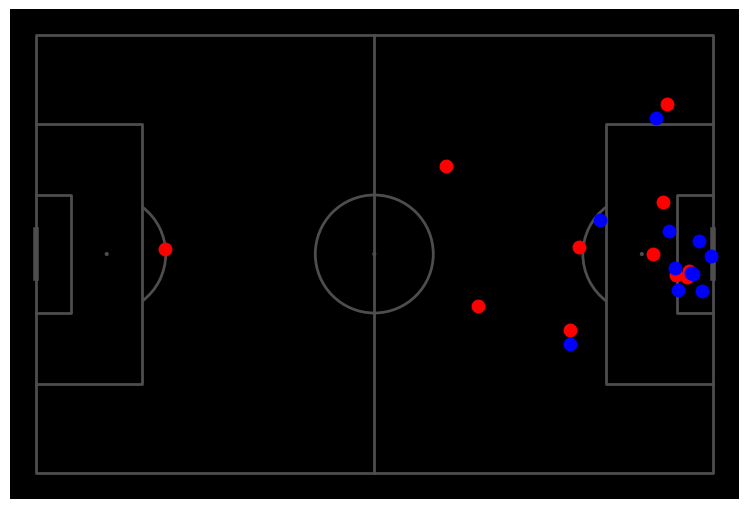

In [32]:
from IPython.display import Video

save_path = 'highest_xg.mp4'
codf_list_sort[0].visualize_frames(save_path)
Video(save_path)

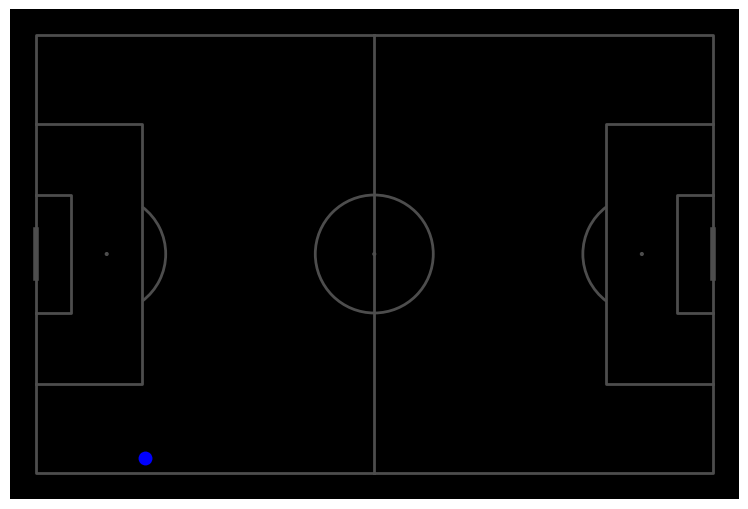

In [ ]:
save_path = 'lowest_xg.mp4'
codf_list_sort[-1].visualize_frames(save_path)
Video(save_path)

---
---

In [ ]:
#setup initial variables
root = get_git_root()

video_dir = Path(root / "soccertrack" / "datasets" / 'SoccerData' / 'TASC' / 'out_videos')

# FIXME:soccertrack.datasetsに置くデータはKaggleからダウンロードするだけにしたいので、それ以外は.gitignoreに入ってる./data に置く
# data_path = Path(root / "soccertrack" / "datasets" / 'SoccerData' / 'train' / 'data.pkl')
data_path = root / "data" / 'SoccerData' / 'train' / 'data.pkl'

# # metrics
# metrics_path = root / "data" / 'SoccerData' / 'metrics_list.csv'
# metrics_df = pd.read_csv(metrics_path)

# #Window to divide pitch by grid
# window_x = 16
# window_y = 12

# #load tracking data
# with open(data_path, 'rb') as f:
#     data = pickle.load(f)

#transform to CoordinatesDataFrame and store in list
#Todo 今後のことを考えると、プレーデータをlistにしておくのは良くないかもしれないので、ジェネレーターにするなどの対応を考える
# ->ter_plays
codf_list = []
for item in tqdm(data.items(), desc="Transform to CoordinatesDataFrame.."):
    idx, seq = item
    codf = CoordinatesDataFrame.from_numpy(seq)
    codf_list.append({"idx": idx, "data": codf})

Transform to CoordinatesDataFrame..: 100%|██████████| 6000/6000 [00:02<00:00, 2266.25it/s]


### Calculation of xG

In [ ]:
from soccertrack.utils import make_video
sample_codf = codf_list[0]

xg_mtx = metrics_df['xG_area'].to_numpy().reshape(window_x, window_y)
rate_xG(sample_codf['data'], xg_mtx, agg_func="w_mean")

NameError: name 'metrics_df' is not defined

### Calculation of xT

In [ ]:
xt

In [ ]:
sample_codf = codf_list[0]
xt_mtx = metrics_df['xT_area'].to_numpy().reshape(window_x, window_y)

rate_xT(sample_codf['data'], xt_mtx, agg_func="w_mean")

0.02927922077922078

### Sorting play quality by xG

現状、ソートされたデータと映像の照らし合わせは、[Google Driveに上げられた動画](https://drive.google.com/drive/folders/1-kPy3tjQIRsbTKqSlBIWlyabolekec4o?usp=share_link)で行なっています。
選択された映像がnotebook上から見れるようになると楽かも知れません（未実装）。

In [ ]:
#sort play quality by xG
codf_list_sort = sorted(
                codf_list, 
                key=lambda codf: rate_xG(codf['data'], xg_mtx, agg_func="w_mean"), 
                reverse=True
                )

sorted_codf_idx = [codf_sort['idx'] for codf_sort in codf_list_sort]

/home/guest/dev_repo/SoccerTrack/soccertrack/rate/agg_func.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return lambda metrics_mtx, ma_count_arr: np.sum(metrics_mtx * ma_count_arr) / np.sum(ma_count_arr)
